#  Прогнозирование количества заказов такси

## ***Введение***

### *Описание проекта:*
    Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
    Значение метрики RMSE на тестовой выборке должно быть не больше 48.
### *Цель проекта:*
    Построить модель для предсказания количества заказов такси на следующий час.
### *Описание данных:*
    Данные в таблице taxi.csv:
        datetime - дата сбора данных
        num_orders - количество заказов
### *План работы:*
        1. Подготовка данных: 
        - выгрузка данных, изучение общей информации
        - создание новых признаков
        - проверка на стационарность
        2. Анализ данных:
        - исследовательский анализ
        - корреляционный анализ
        3. Обучение модели
        4. Тестирование
        5. Общий вывод

In [1]:
! pip install -q sweetviz
! pip install -q phik
! pip install -q lightgbm
! pip install -q --upgrade scikit-learn
! pip install -q optuna-integration


[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
# Импорты из стандартной библиотеки
import os
import warnings

# Импорты сторонних библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Анализ
import sweetviz as sv
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from statsmodels.tsa.stattools import adfuller, kpss

# Временные ряды
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

# Подготовка данных и поиск
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from optuna.integration import OptunaSearchCV

# Пайплайн
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Модели
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor

# Метрики
from sklearn.metrics import mean_squared_error, make_scorer

## Подготовка

### Загрузка данных

Получим данные, сразу установим даты в качестве индексов таблицы

In [3]:
if os.path.exists('/datasets/taxi.csv'):
    df_taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
else:
    df_taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Ознакомимся с таблицей

In [4]:
pd.set_option('display.max_columns', None)
df_taxi

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Все заявленные признаки присутствуют, названия столбцов в норме

In [5]:
display(df_taxi.info(), df_taxi.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Пропусков нет. Признаков для обучения модели недостаточно. Добавим некоторые признаки.

### Создание признаков

Перед созданием признаков отсортируем таблицу по индексу и ресемплируем данные по одному часу

In [6]:
df_taxi.index.is_monotonic_increasing

True

In [7]:
df_taxi_h = df_taxi.resample('1H').sum()

#### Календарные признаки

Сначала создадим календарные признаки. 

In [8]:
df_taxi.index.min(), df_taxi.index.max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:50:00'))

Заметим, что данные по одному году, значит выделять год в качестве признака не стоит, будет константное значение, кроме того, сложно будет отследить сезонность по месяцам по той же причине, а значит не стоит выделять месяц как отдельный признак.

Для начала рассмотрим весь временной ряд

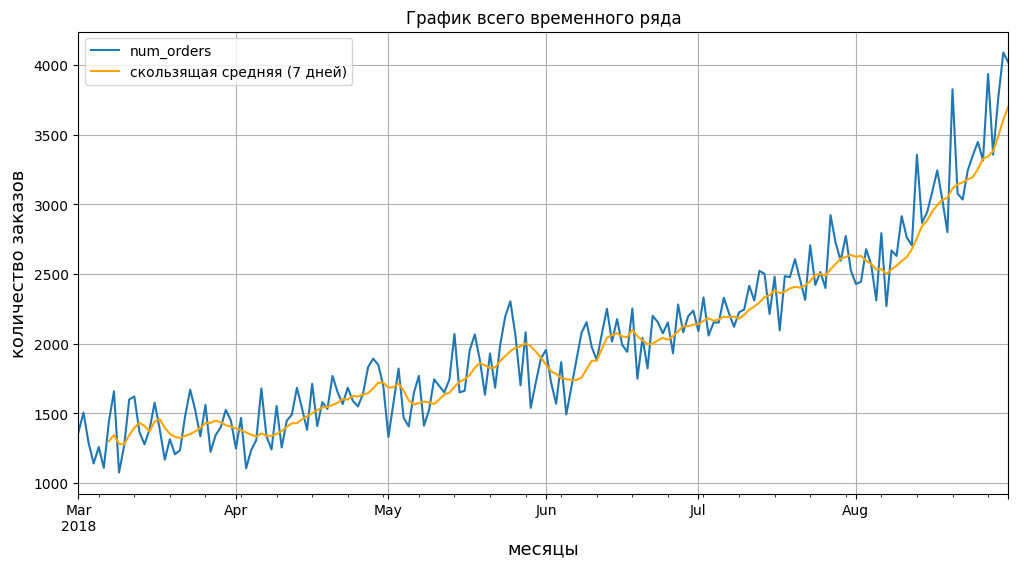

In [9]:
df_taxi_d = df_taxi.resample('1D').sum()
rolling_mean = df_taxi_d.rolling(window=7).mean()

plt.figure(figsize=(12, 6))
df_taxi_d.plot(ax=plt.gca())
plt.plot(rolling_mean, label='скользящая средняя (7 дней)', color='orange')
plt.title('График всего временного ряда')
plt.xlabel('месяцы', fontsize=13)
plt.ylabel('количество заказов', fontsize=13)
plt.legend()
plt.grid()
plt.show()

Количество заказов неуклонно увеличивается. С марта по август количество заказов увеличилось почти в 4 раза. 

Проверим сезонность данных внутри одного дня, недели.

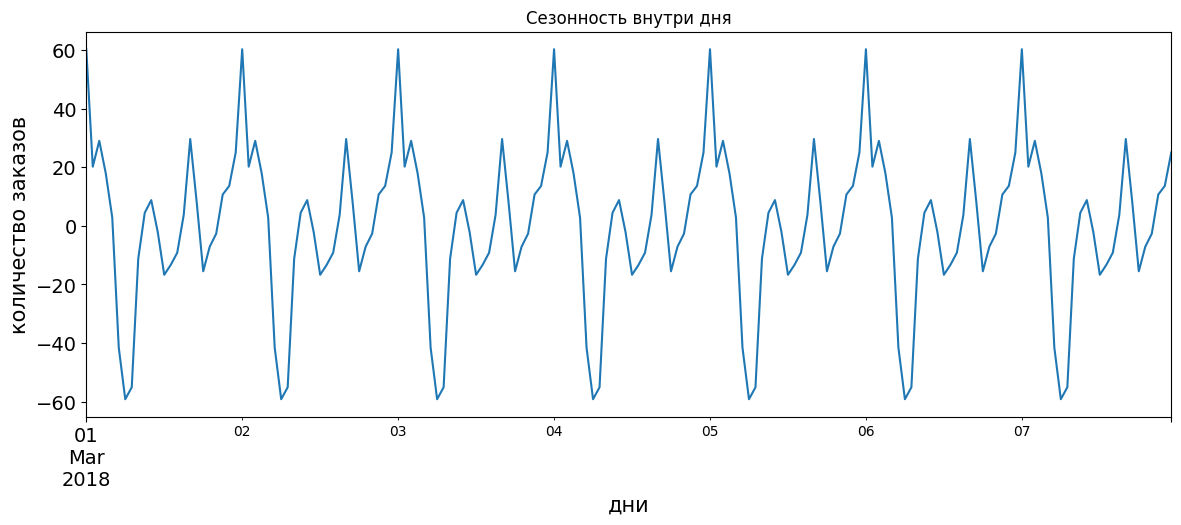

In [10]:
# Сезонность внутри дня
decomposed = seasonal_decompose(df_taxi_h)
plt.figure(figsize=[14, 5])
ax = decomposed.seasonal.head(168).plot(ax=plt.gca());
plt.title('Сезонность внутри дня')
plt.xlabel('дни', fontsize=15)
plt.ylabel('количество заказов', fontsize=15)
ax.tick_params(axis='y', labelsize=14) 
ax.tick_params(axis='x', labelsize=14) 
plt.show()

Сезонность внутри дня прослеживается, паттерн повторяется ото дня ко дню. Возможно это связано с тем, что ночью клиентов стабильно меньше, а к вечеру изо дня в день клиентов становится все больше. Стоит добавить признак "час"

In [11]:
df_taxi_h['hour'] = df_taxi_h.index.hour

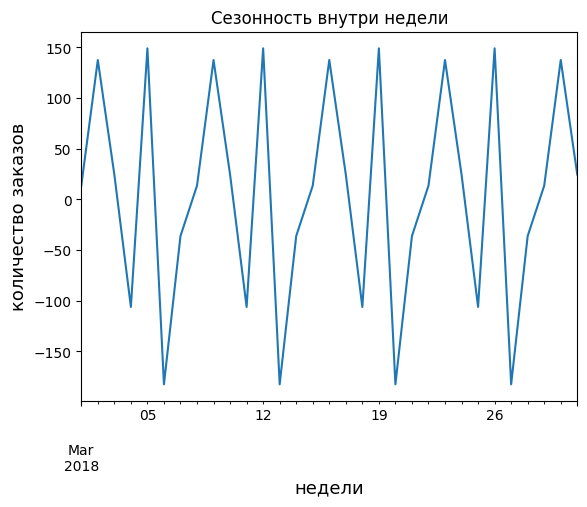

In [12]:
# Сезонность внутри недели
decomposed = seasonal_decompose(df_taxi_d)
decomposed.seasonal['2018-03'].plot(ax=plt.gca());
plt.title('Сезонность внутри недели')
plt.xlabel('недели', fontsize=13)
plt.ylabel('количество заказов', fontsize=13)
plt.show()

Прослеживается сезонность внутри недели. Она может обуславливаться тем, что в начале рабочей недели минимум клиентов, а ближе к выходным количество клиентов возрастает. Стоит добавить признак "день недели".

In [13]:
df_taxi_h['dayofweek'] = df_taxi_h.index.dayofweek

#### Лаги

Данные ресемплированы по часам и мы заметили сезонность внутри дня. Попробуем изучить автокорреляцию 24 лагов.

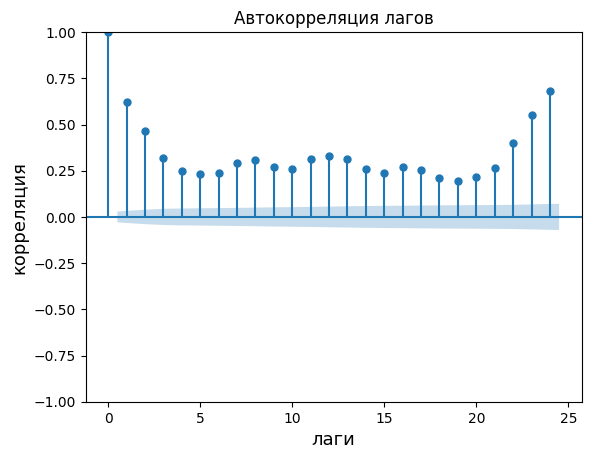

In [14]:
lags = plot_acf(df_taxi_h['num_orders'], lags=24)
plt.title('Автокорреляция лагов')
plt.xlabel('лаги', fontsize=13)
plt.ylabel('корреляция', fontsize=13)
plt.show()

Все лаги имеют весомый уровень автокорреляции, добавим все 24 лага в качестве новых признаков.

In [15]:
for lag in range(1, 25):
        df_taxi_h['lag_{}'.format(lag)] = df_taxi_h['num_orders'].shift(lag)

#### Скользящая средняя

Возьмем скользящую среднюю с окном 24, таким образом мы сможем сгладить данные учитывая суточные колебания.

In [16]:
df_taxi_h['rolling_mean'] = df_taxi_h['num_orders'].shift().rolling(24).mean()

### Проверка на стационарность

Проведем тест Дики-Фуллера и выполним KPSS критерий для проверки временного ряда на стационарность.

In [17]:
adf_result = adfuller(df_taxi_h['num_orders'])
p = adf_result[1]
alpha = 0.05
if p < alpha:
    print(f'Тест Дики-Фуллера:\np-value: {p}\n' \
    f'p-value меньше выбранного уровня значимости (0.05).\n' \
    f'Отвергаем нулевую гипотезу о нестационарности временного ряда.')
else:
    print(f'Тест Дики-Фуллера:\np-value: {p}\n' \
    f'p-value не меньше выбранного уровня значимости (0.05).\n' \
    f'Нельзя отвергнуть нулевую гипотезу о НЕ стационарности временного ряда.')

Тест Дики-Фуллера:
p-value: 0.028940051402613316
p-value меньше выбранного уровня значимости (0.05).
Отвергаем нулевую гипотезу о нестационарности временного ряда.


По результатам теста Дики-Фуллера можно предположить, что временной ряд стационарен.

Используем KPSS критерий, для проверки нулевой гипотезы о том, что 

In [18]:
warnings.simplefilter("ignore", category=UserWarning)
kpss_result = kpss(df_taxi_h['num_orders'])
p = kpss_result[1]
if p < alpha:
    print(f'KPSS критерий:\np-value: {p}\n' \
    f'p-value меньше выбранного уровня значимости (0.05).\n' \
    f'Отвергаем нулевую гипотезу о стационарности временного ряда.')
else:
    print(f'KPSS критерий:\np-value: {p}\n' \
    f'p-value не меньше выбранного уровня значимости (0.05).\n' \
    f'Нельзя отвергнуть нулевую гипотезу о стационарности временного ряда.')


KPSS критерий:
p-value: 0.01
p-value меньше выбранного уровня значимости (0.05).
Отвергаем нулевую гипотезу о стационарности временного ряда.


KPSS критерий показывает, что ряд нестационарный.

Учитывая общий график временного ряда с явным увеличением среднего количества заказов, а так же результаты KPSS критерия, можно предположить, что ряд нестационарный.

### Вывод:
    - добавили в качестве календарных признаков: часы, дни недели
    - добавили 24 лага
    - добавили скользящую среднюю с окном 24

## Анализ

### Исследовательский анализ

Проведем анализ признака num_orders, всех добавленных календарных признаков, скользящей средней, а так же наиболее значимых лагов

In [19]:
report = sv.analyze([df_taxi_h[['num_orders', 'hour', 'dayofweek', 'lag_1', 'lag_2', \
                                'lag_22', 'lag_23', 'lag_24', 'rolling_mean']], 'Taxi'])

                                             |      | [  0%]   00:00 -> (? left)


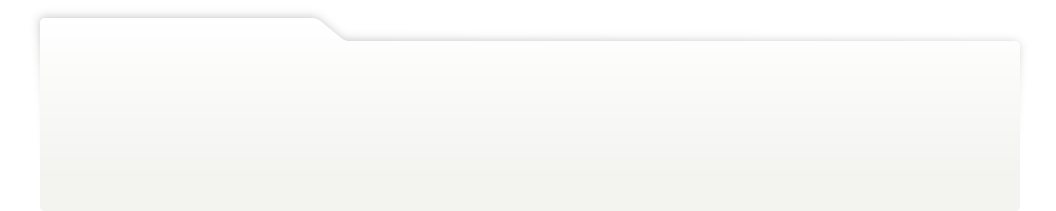
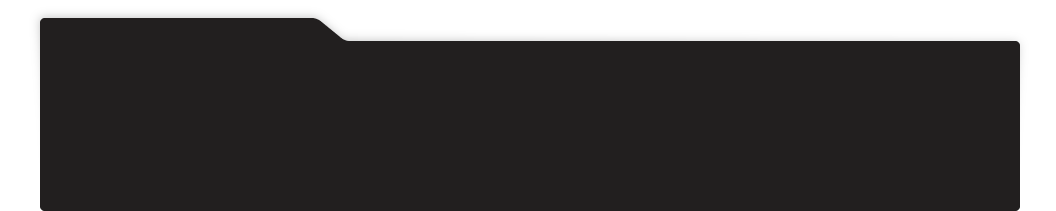
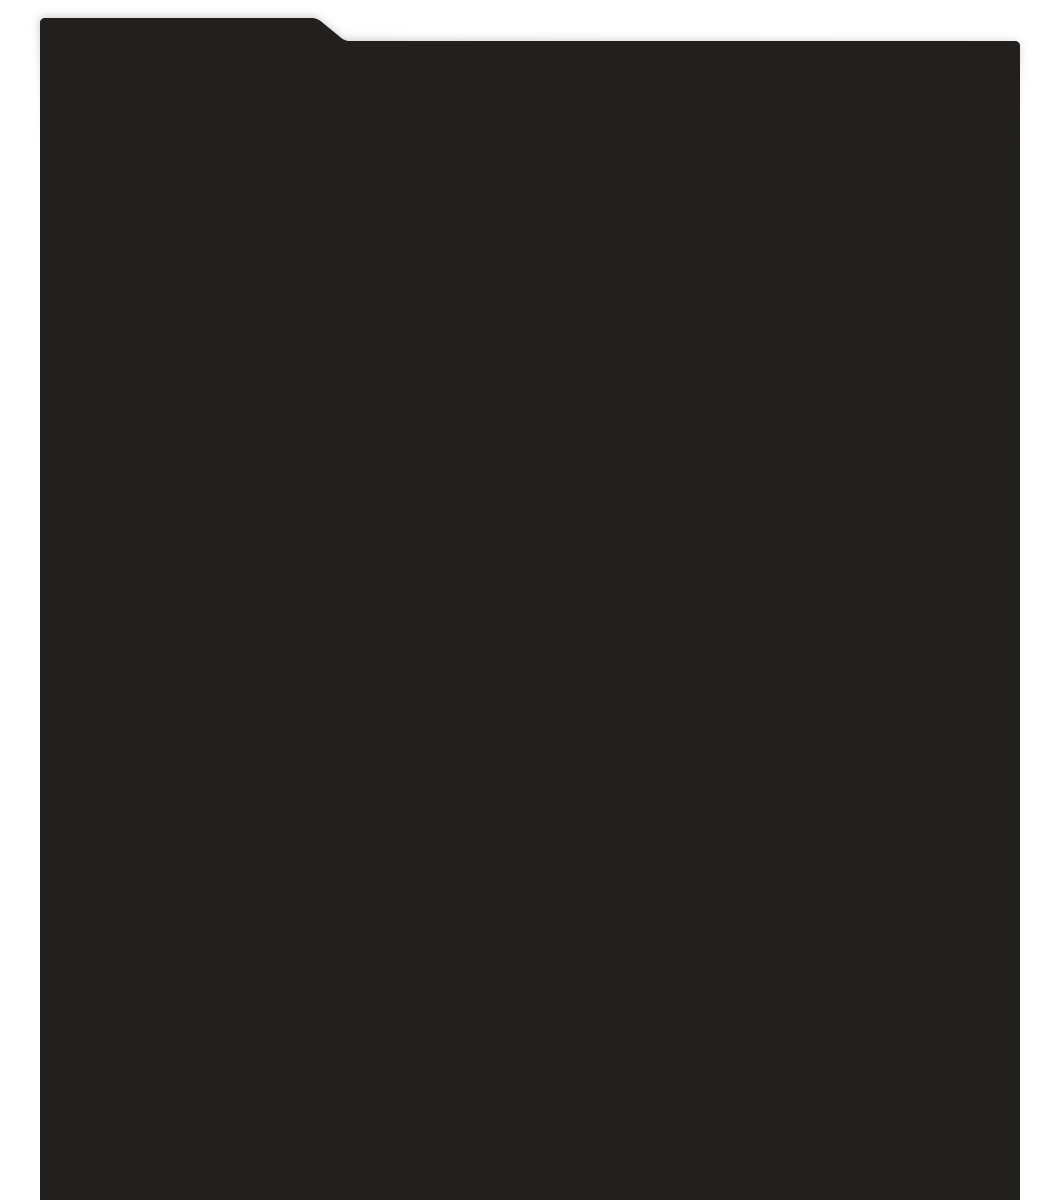
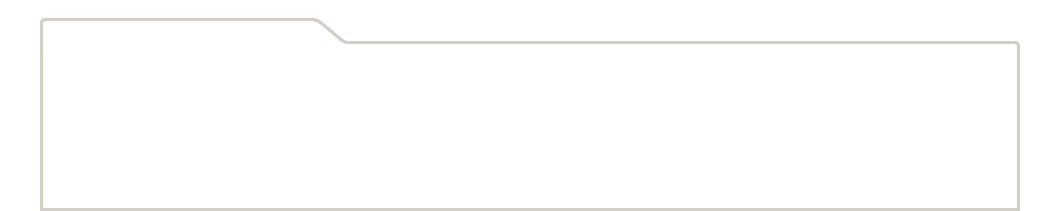
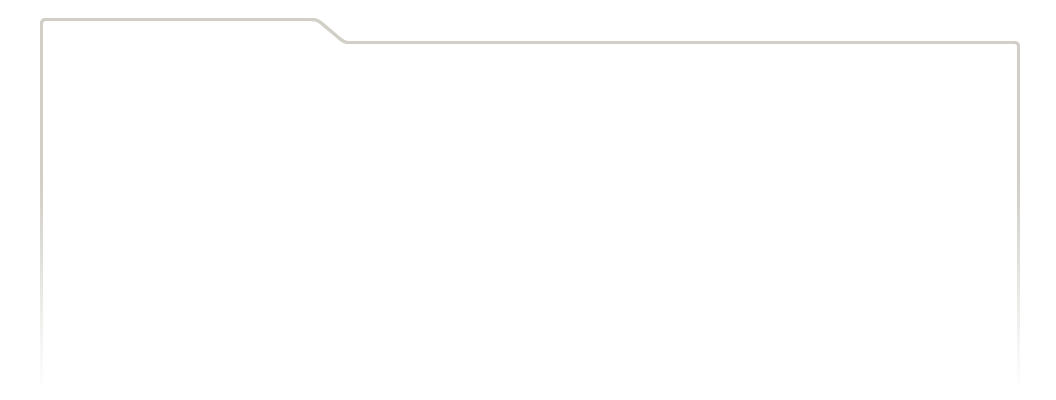
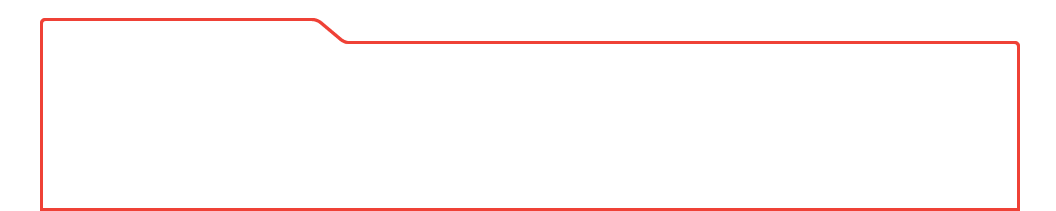
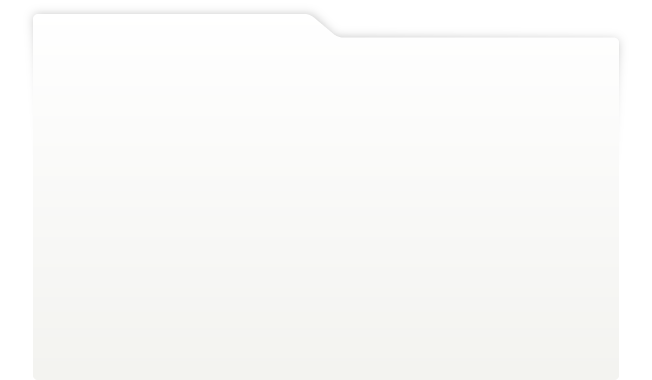
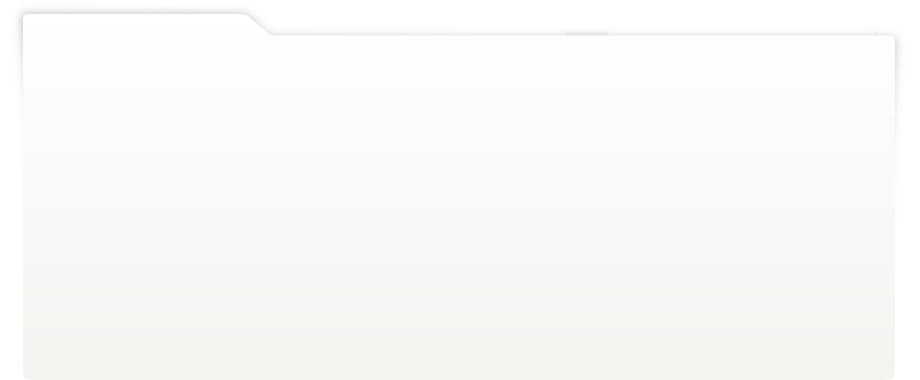
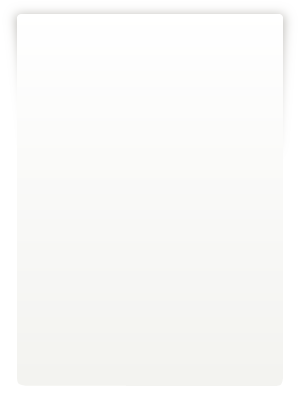
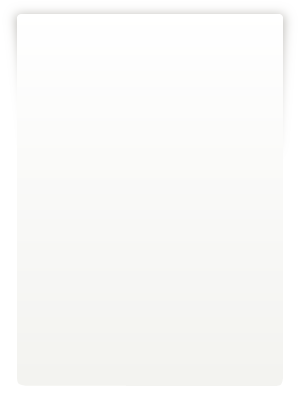
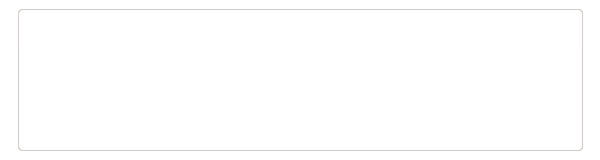
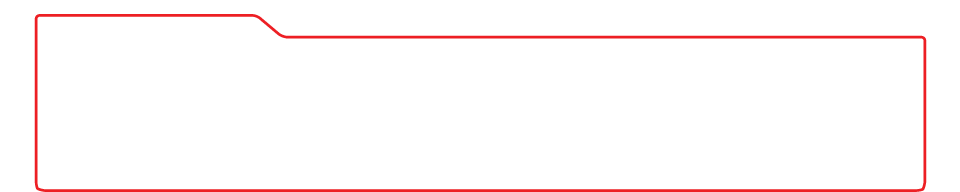
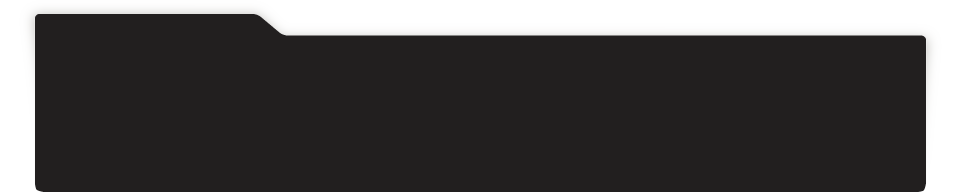
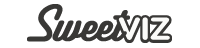
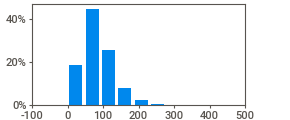
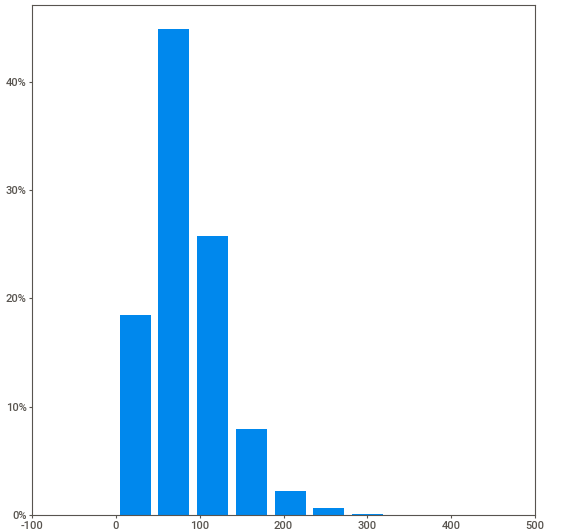
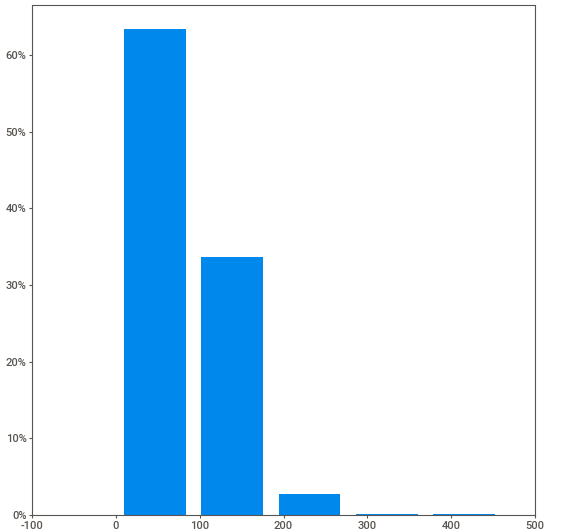
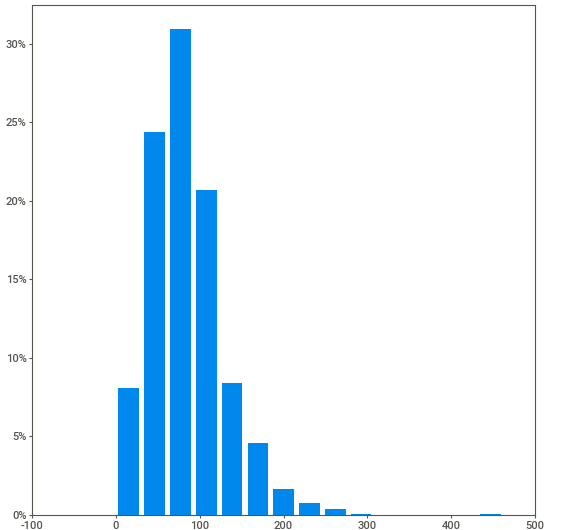
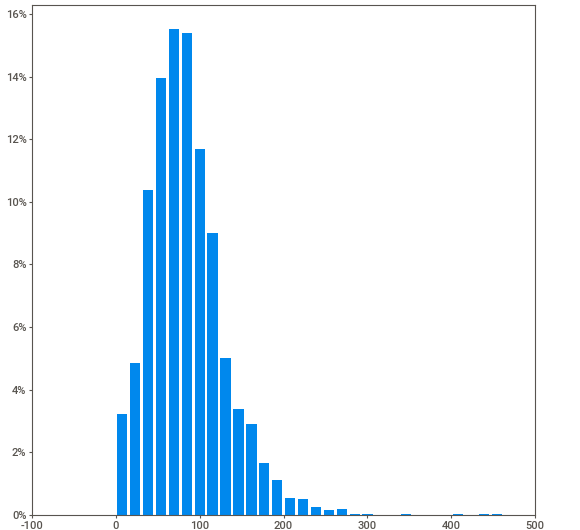
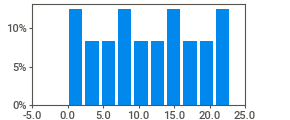
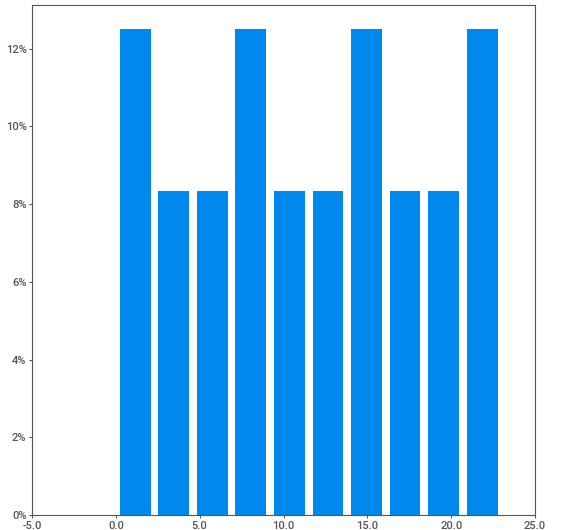
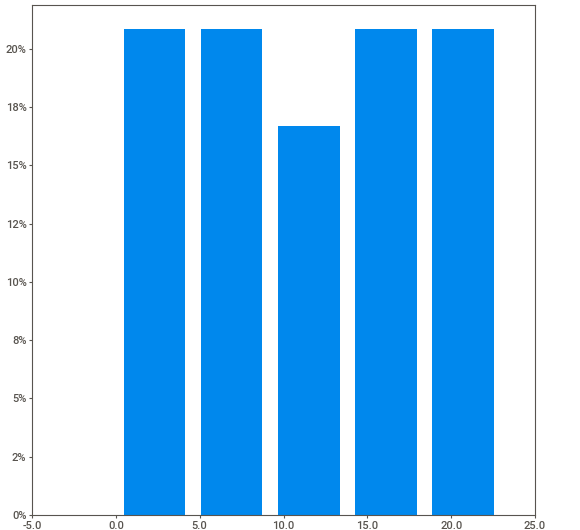
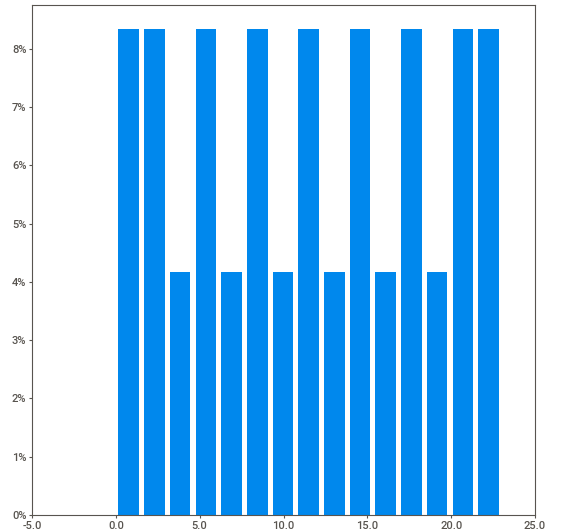
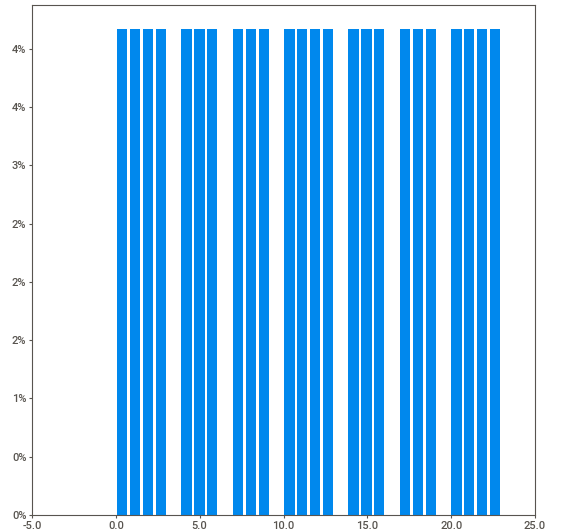
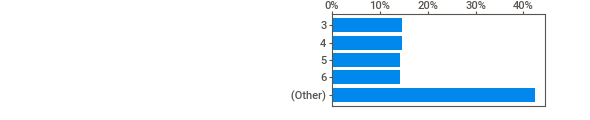
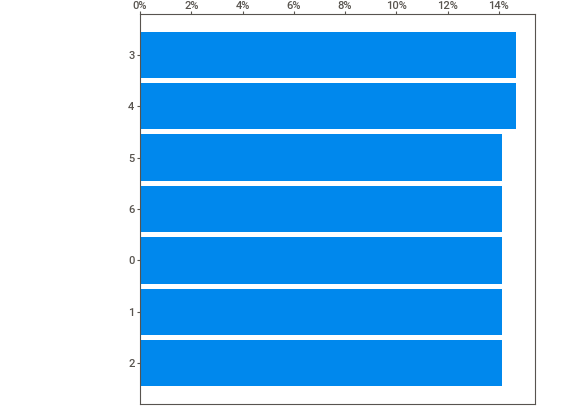
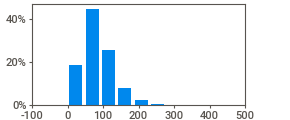
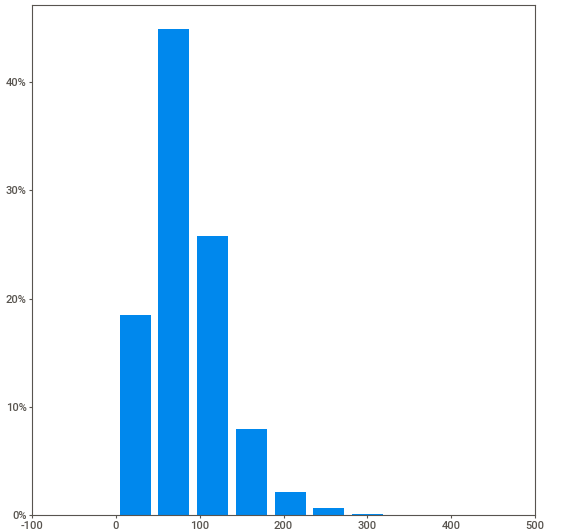
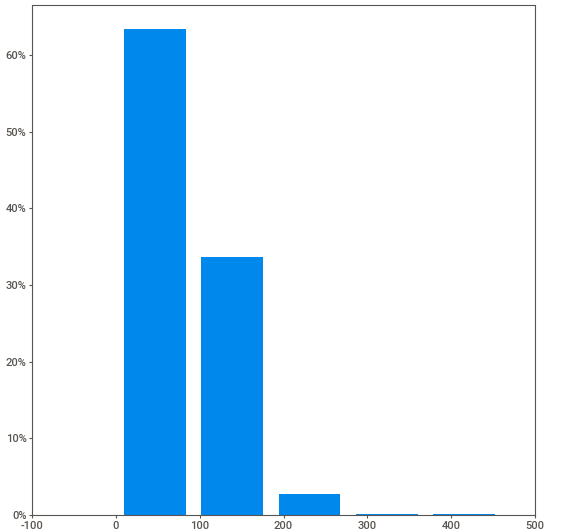
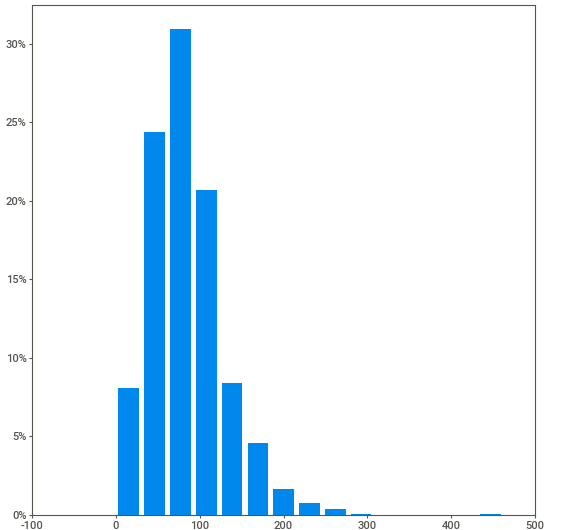
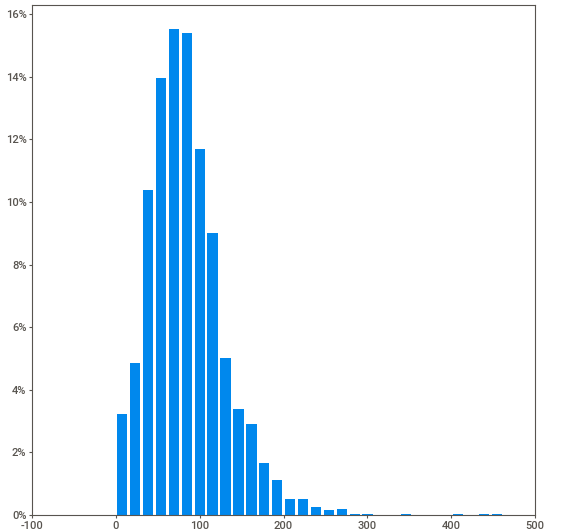
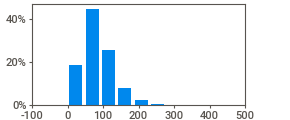
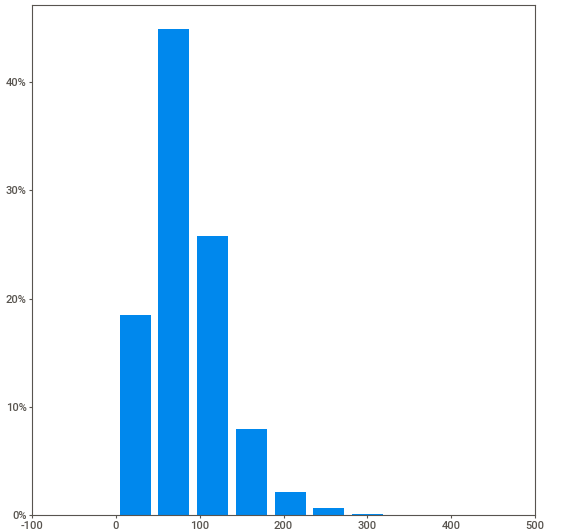
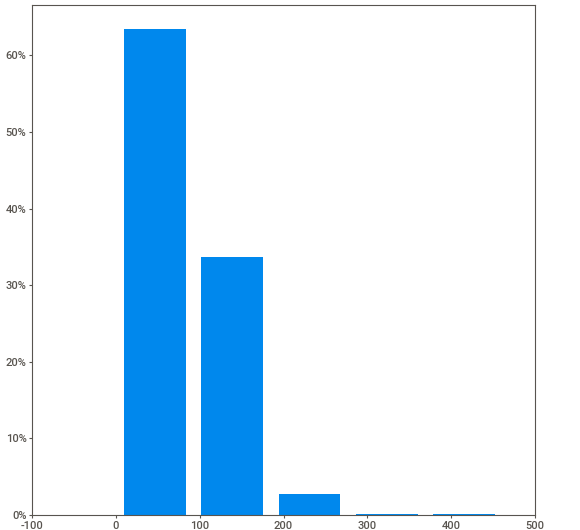
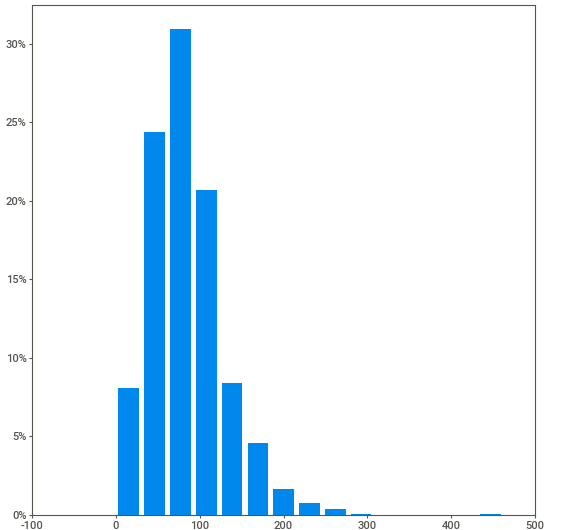
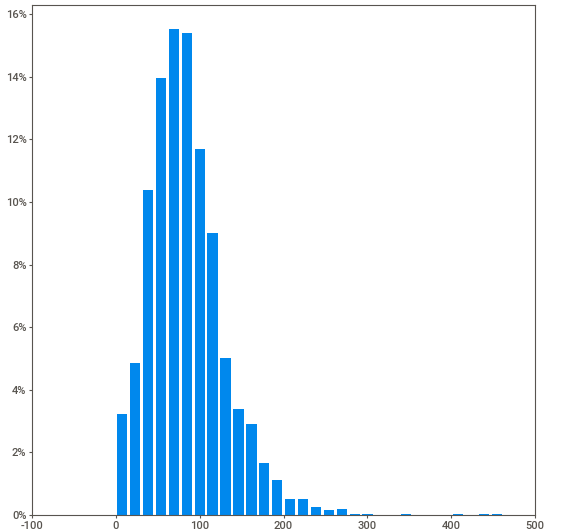
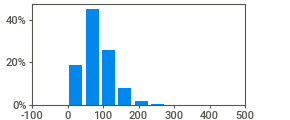
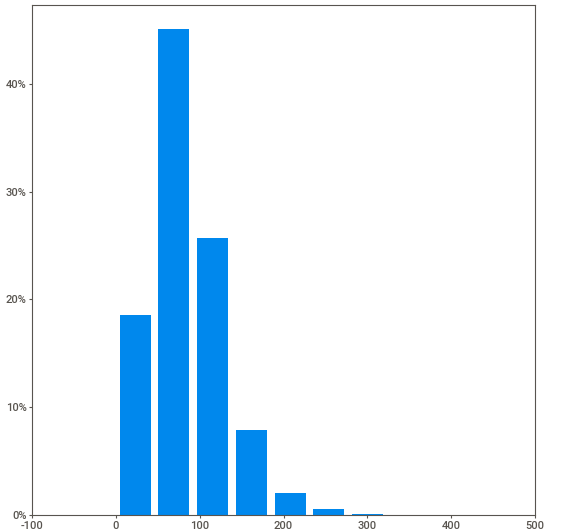
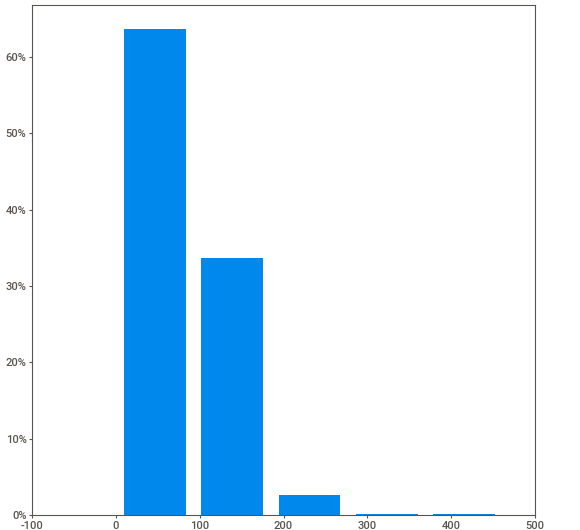
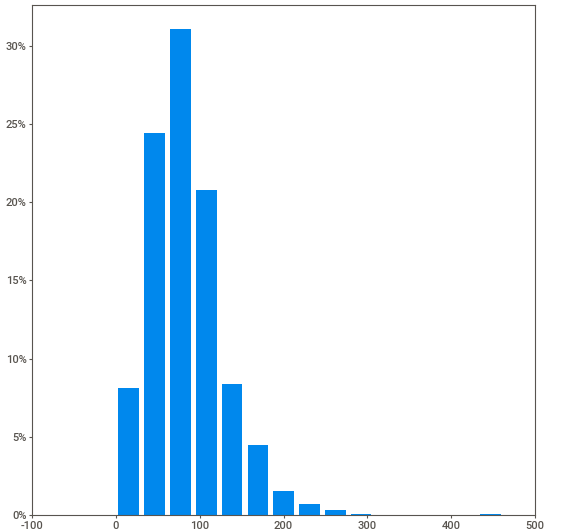
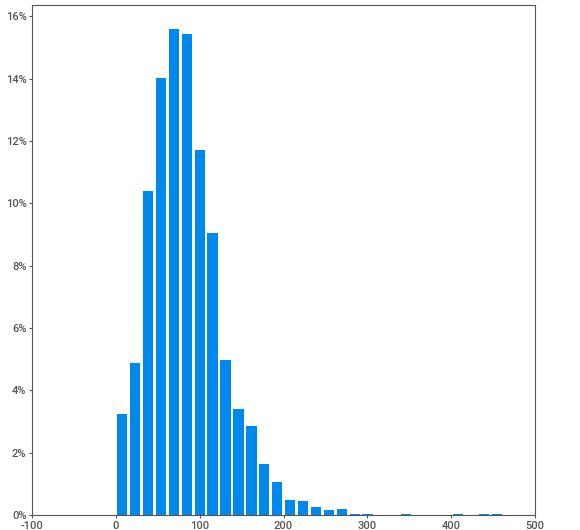
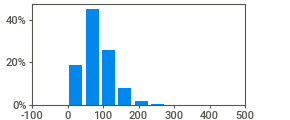
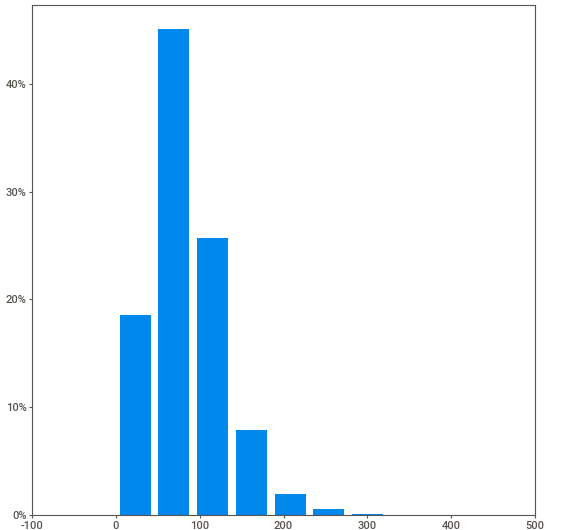
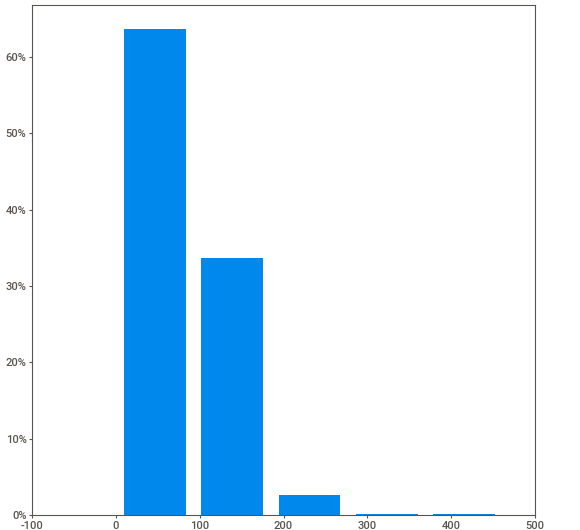
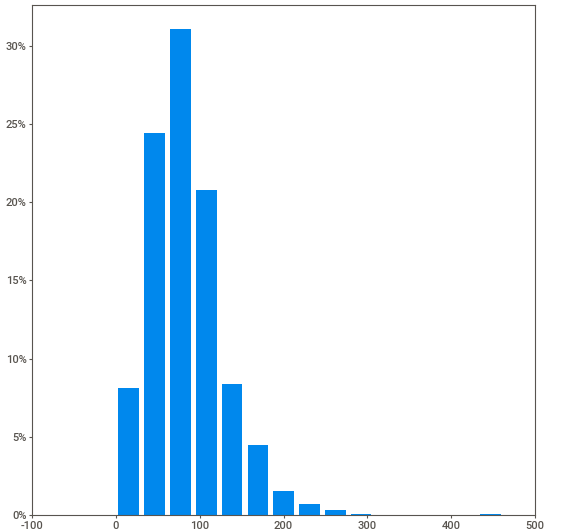
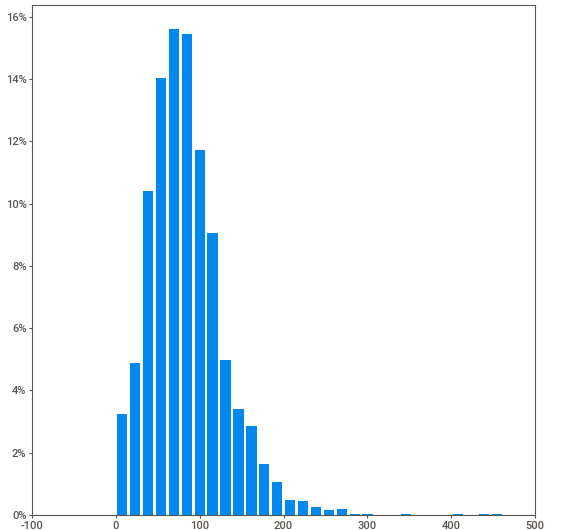
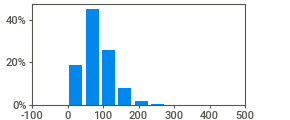
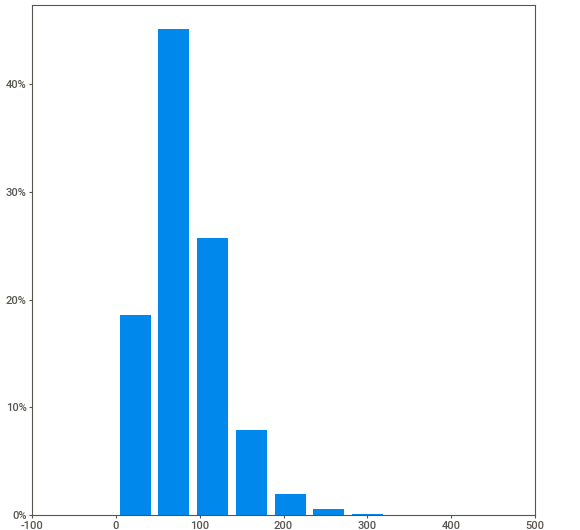
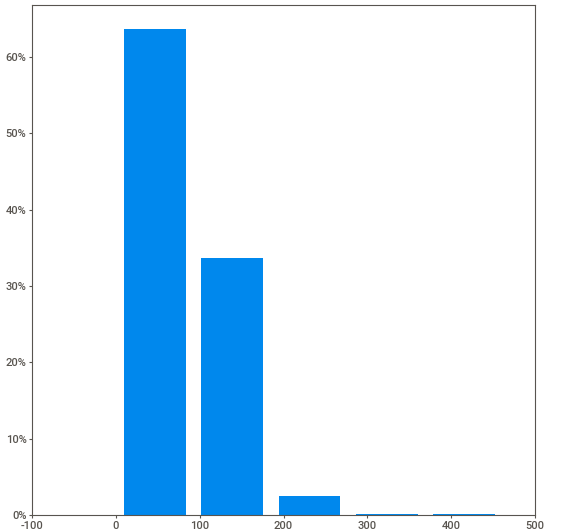
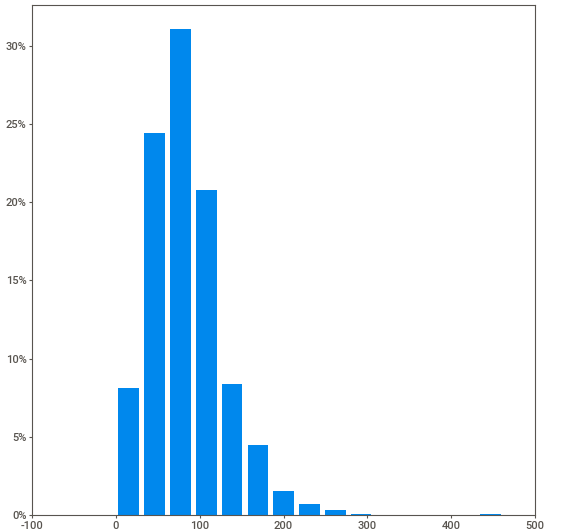
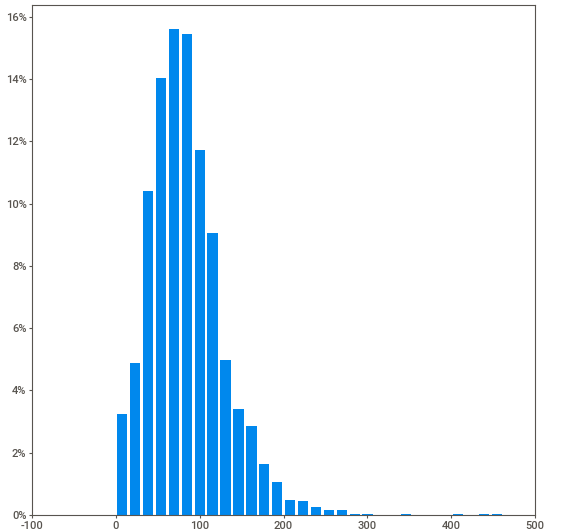
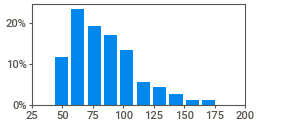
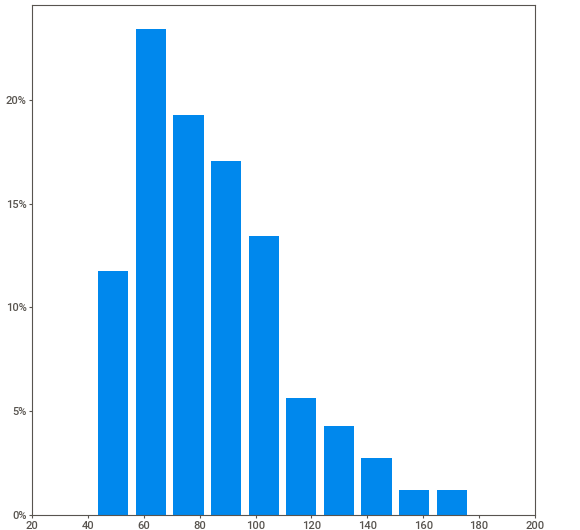
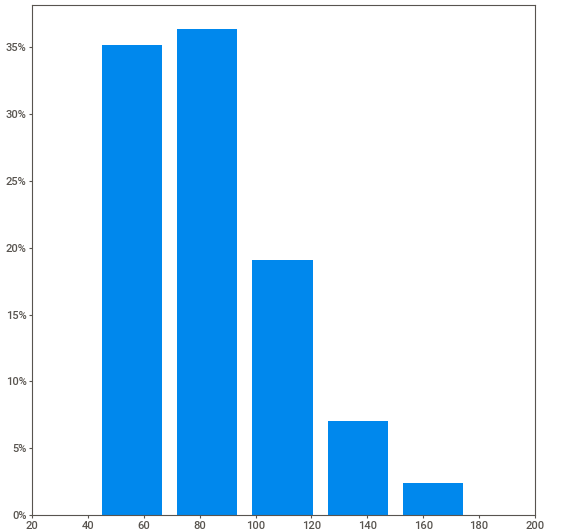
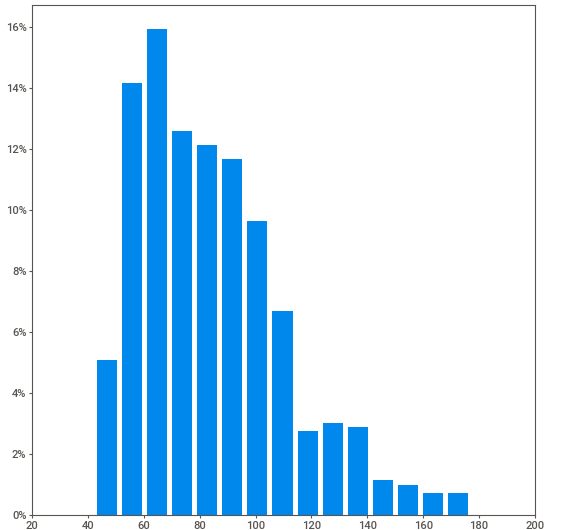
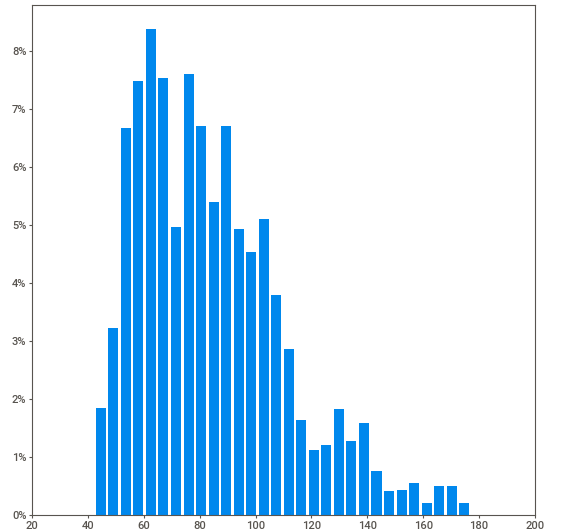
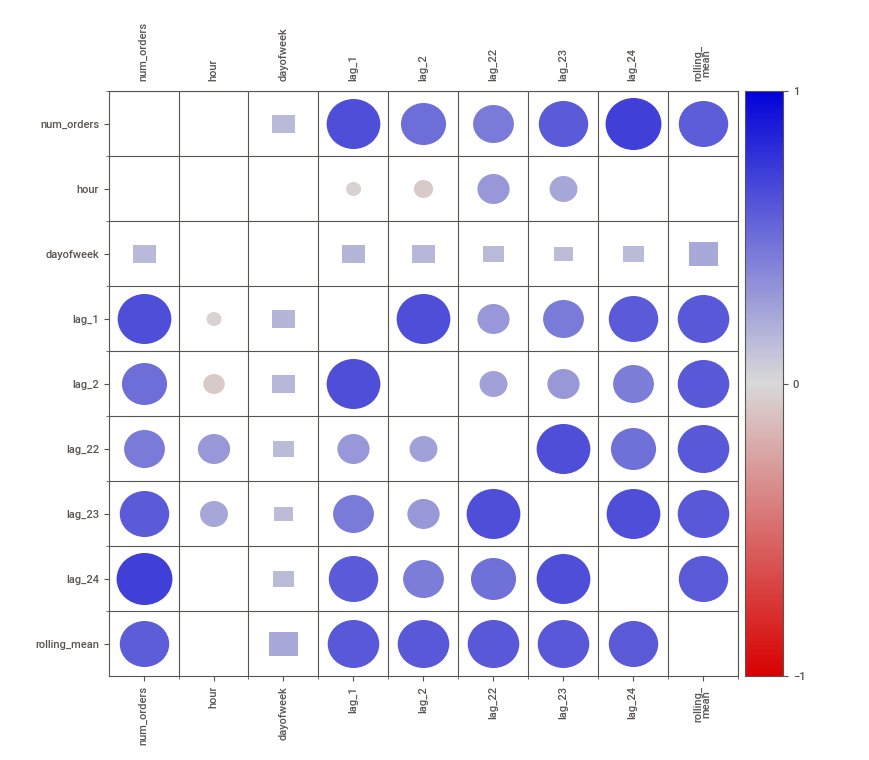
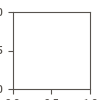

In [20]:
report.show_notebook()

Появились пропуски из-за включения лагов в качестве признаков. Сразу можно заметить корреляцию между целевым признаком и лагами. Распределения количественных признаков нормальными не являются.

Построим боксплоты для отслеживания аномальных значений и выбросов.

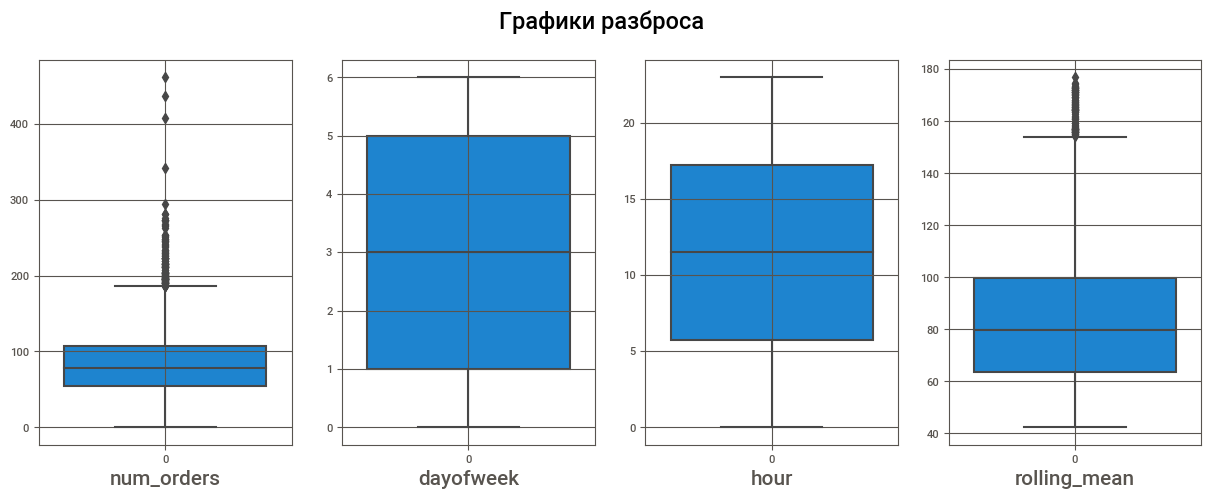

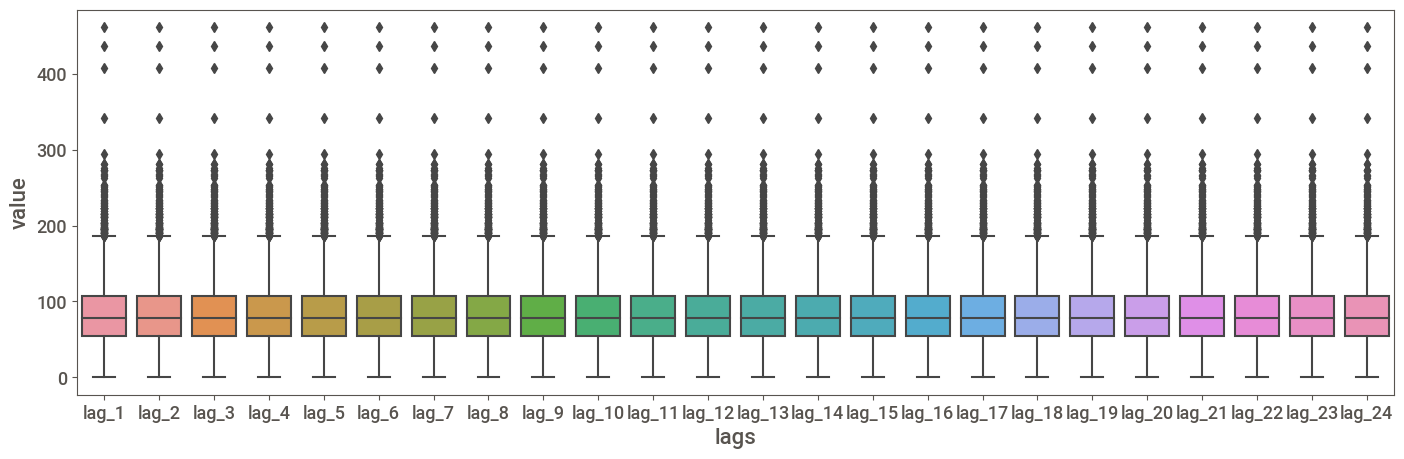

In [21]:
plt.figure(figsize=[15, 5])
plt.suptitle('Графики разброса', size=17)
df_box = df_taxi_h[['num_orders', 'dayofweek', 'hour', 'rolling_mean']]
df_melted = df_taxi_h.iloc[:, 3:27].melt(var_name='lags', value_name='Value')

for i in range(4):
    plt.subplot(1, 4, i+1)
    sns.boxplot(data=df_box.iloc[:, i])
    plt.xlabel(df_box.columns[i], size=15)
    plt.grid()
plt.show()

plt.figure(figsize=[17, 5])
ax = sns.boxplot(x='lags', y='Value', data=df_melted)
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)
ax.set_xlabel('lags', fontsize=16)
ax.set_ylabel('value', fontsize=16)
plt.show()

Наблюдаются выбросы в некоторых признаках, но мы не будем их удалять, что бы сохранить последовательность временного ряда.

### Корреляционный анализ

Изучим подробнее корреляцию признаков (берем самые весомые лаги)

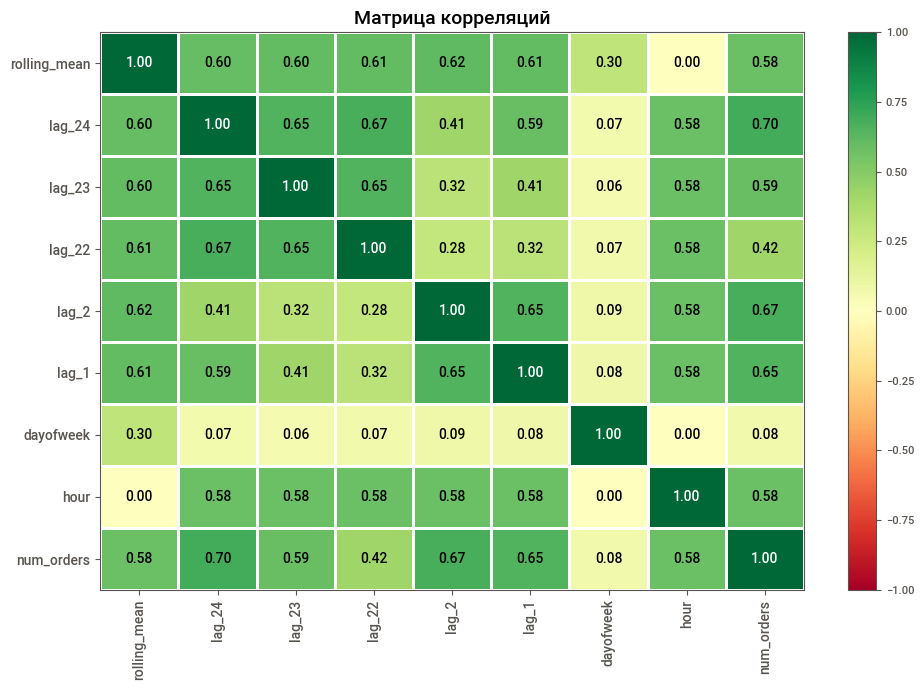

In [22]:
df_taxi_corr = df_taxi_h[['num_orders', 'hour', 'dayofweek', 'lag_1', 'lag_2', \
                          'lag_22', 'lag_23', 'lag_24', 'rolling_mean']].dropna()
corr_matrix = phik_matrix(df_taxi_corr, interval_cols=df_taxi_corr.drop(['dayofweek', 'hour'], axis=1).columns)

plot_correlation_matrix(corr_matrix.values, x_labels=corr_matrix.columns, y_labels=corr_matrix.index, \
                        title='Матрица корреляций', figsize=(10, 7))

Матрица показывает хорошую корреляцию со всеми выделенными признаками, кроме dayofweek. Мультиколлинеарности не наблюдается.

### Вывод:
    - появились пропуски в признаках
    - распределение количественных признаков ненормально
    - замечены выбросы в данных, одгако принято решение их не удалять
    - все признаки, кроме dayofweek хорошо коррелируют с целевым признаком 

## Обучение

Выделим выборки

In [23]:
RANDOM_STATE = 42
TEST_SIZE = 0.1

X_train, X_test, y_train, y_test = train_test_split(df_taxi_h.drop('num_orders', axis=1), 
                                                    df_taxi_h['num_orders'],
                                                    shuffle=False,
                                                    test_size=TEST_SIZE)

Пайплайны для работы с признаками

In [24]:
num_col = X_train.drop(['hour', 'dayofweek'], axis=1).columns.tolist()
cat_col = ['hour', 'dayofweek']

num_pipe = Pipeline(
    [
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler())
    ]
)


cat_pipe = Pipeline(
    [
        ('imputer_cat', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('encoder', OrdinalEncoder()) # пробовал и OneHotEncoder, но с OrdinalEncoder 
                                      # результаты были немного лучше + удобнее рассматривать важность признаков
    ]
)

In [25]:
preprocessor = ColumnTransformer(
    [
        ('num', num_pipe, num_col), 
        ('cat', cat_pipe, cat_col),
    ], 
    remainder='passthrough'
)

In [26]:
pipe_final = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', LinearRegression())
    ])

Перебор моделей и их гиперпараметров

In [27]:
param_grid = [
    {
         'model': [Lasso(random_state=RANDOM_STATE)],
         'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
     },
    {
        'model': [Ridge(random_state=RANDOM_STATE)],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    },
     {
        'model': [KNeighborsRegressor()],
        'model__n_neighbors': range(2, 5),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
     },
    {
        'model':[DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'model__max_depth': range(2, 5),
        'preprocessor__num': ['passthrough']
    },
      {
        'model':  [LGBMRegressor(random_state=RANDOM_STATE)],
         'model__boosting_type': ['gbdt', 'dart'],
         'model__num_leaves': range(20,30),
         'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
     }
]

In [28]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scorer = make_scorer(rmse, greater_is_better=False)

Используем TimeSeriesSplit, так как работаем с временными рядами. Важно сохранить хронологический порядок и учесть временную зависимость данных

In [29]:
%%time
tscv = TimeSeriesSplit(n_splits=5)
search = RandomizedSearchCV(pipe_final, param_grid, cv=tscv, scoring=scorer, n_jobs=-1, random_state=RANDOM_STATE)
search.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2699
[LightGBM] [Info] Number of data points in the train set: 664, number of used features: 27
[LightGBM] [Info] Start training from score 56.969880
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['lag_1',
                                                                                'lag_2',
                                                                                'lag_3',
                                                                                'lag_4',
                                                                                'lag_5',
                                                                                'lag_6',
                                                                                'lag_7',
                                                                                'lag_8',
                                                                                'lag_9',
                                                                                'lag_10...
                                         'model__max_depth': range(2, 5),
                                         'preprocessor__num': ['passthrough']},
                                        {'model': [LGBMRegressor(random_state=42)],
                                         'model__boosting_type': ['gbdt',
                                                                  'dart'],
                                         'model__num_leaves': range(20, 30),
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(rmse, greater_is_better=False, response_method='predict'))

In [30]:
search.best_score_ * -1

24.8512874626876

RMSE лучшей модели равно 24,8. Лучшая модель LGBMRegressor(num_leaves=23, random_state=42)

### Вывод:
    - разбили на выборки, сделав тестовую выборку размером 10% от исходных данных
    - перебрали множество моделей с помощью RandomizedSearchCV() и использовали TimeSeriesSplit() в качестве метода кросс-валидации.
    - получили показатель RMSE равный 24,8 для лучшей модели LGBMRegressor(num_leaves=23, random_state=42)

## Тестирование

Рассчитаем RMSE на тестовой выборке для лучшей модели

In [31]:
best_model = search.best_estimator_
result = best_model.predict(X_test)

In [32]:
rmse(y_test, result)

41.85504778311295

RMSE показывает результат на тестовой выборке хуже, чем на тренировочной, однако все же меньше чем 48.

Изучим значимость признаков

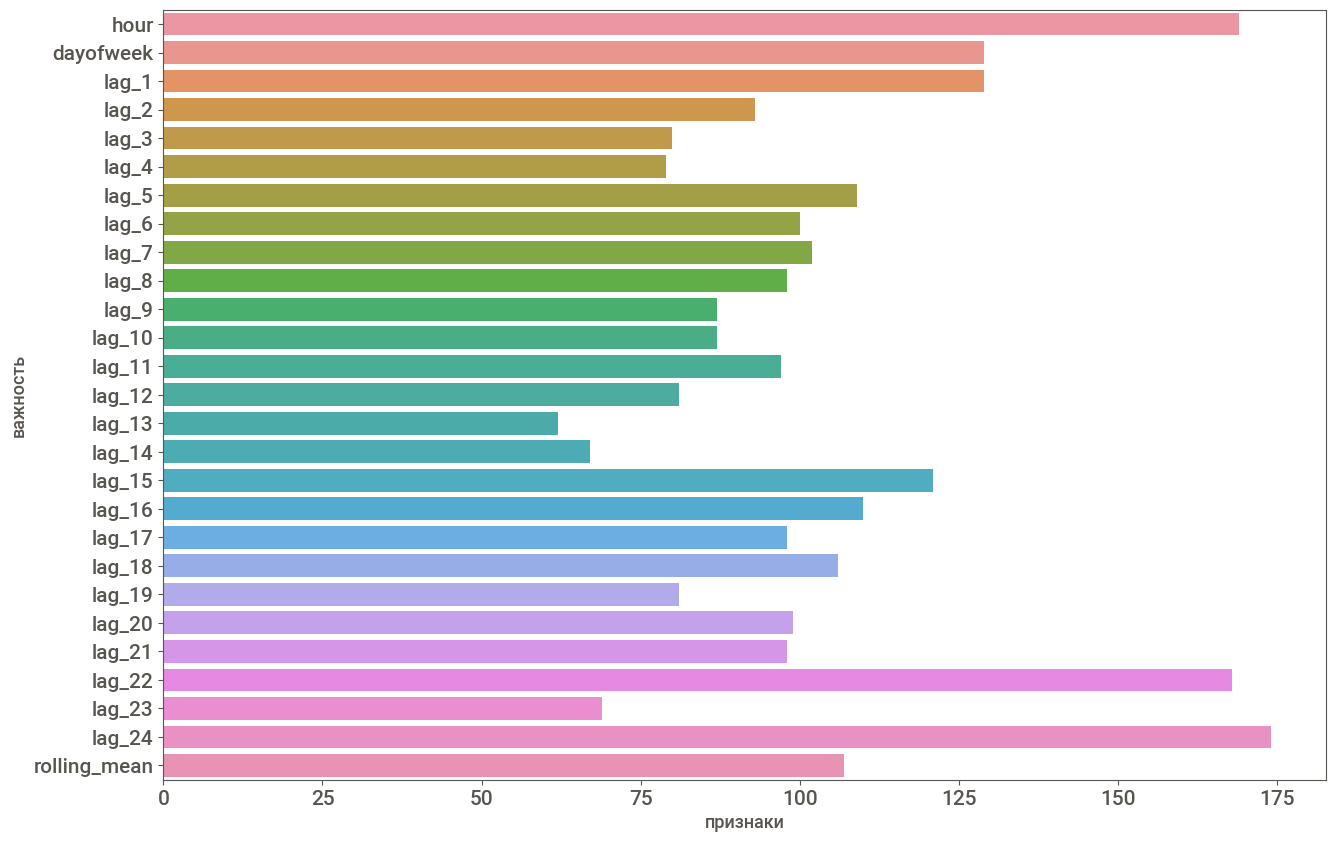

In [33]:
best_model = search.best_estimator_.named_steps['model']
feature_importances = best_model.feature_importances_

dd = pd.DataFrame(feature_importances, X_test.columns).reset_index()
plt.figure(figsize=(15, 10));
ax = sns.barplot(y=dd['index'], x=dd[0], orient='h');
plt.xlabel('признаки', fontsize=13);
plt.ylabel('важность', fontsize=13);
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15) 

### Вывод:
    - показатель RMSE на тестовой выборке ухудшился (41,8), но в пределах допустимого.
    - выяснили, что все используемые признаки достаточно значимы для предсказания количества заказов такси на следующий час. Самыми значимыми являются hour, lag_22 и lag_24

## ***Общий вывод***

    Главная задача:

        Построить модель для предсказания количества заказов такси на следующий час.
        
    Этапы работы:
        1. Подготовка данных:
            - выгрузили данные, установив в качестве индексов даты.
            - создали новые признаки, такие как час, день недели, 24 лага и скользящую среднюю с окном 24
            - проверили данные на стационарность с помощью теста Дики-Фуллера и KPSS критерия
        2. Анализ данных: провели исследовательский и корреляционный анализ
        3. Обучение модели: 
            - разбили данные на выборки, сделав тестовую выборк размером 10% от исходных данных.
            - перебрали множество моделей с помощью RandomizedSearchCV() и использовали TimeSeriesSplit() в качестве метода кросс-валидации.
            - получили показатель RMSE равный 24,8 для лучшей модели LGBMRegressor(num_leaves=23, random_state=42)
        4. Тестирование: 
            - рассчитали значение rmse на тестовой выборке, получили 41,8 (в пределах нормы)
            - изучили значимость всех признаков. Все созданные признаки оказались достаточно значимыми.

**Лучшая модель:  LGBMRegressor(num_leaves=23, random_state=42) с показателем rmse на тестовой выборке 41,8**

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48